## Simple Mie Phase function tutorial
This is just the first test, more to follow. 

---
In the following, we will just walk through how to compute greek coefficients (which will be require for radiative transfer calculations) as well as actual phase matrices from the Mie theory.

---
First let's use the required packages

In [1]:
using RadiativeTransfer.PhaseFunction
using Distributions
using Plots

In [2]:
# Aerosol particle distribution and properties 
μ  = 0.3        # Log-normal median radius [μm]
σ  = 2.0        # Log-normal stddev of radius
r_max = 30.0    # Maximum radius [μm]
n  = 2500       # Number of quadrature points for integrating of size dist.
nᵣ = 1.3        # Real part of refractive index
nᵢ = 0.0        # Imag part of refractive index (sign changed, use only + here)

# Create a Size Distribution (from Julia's Distributions package)
size_distribution = LogNormal(log(μ), log(σ))

# Create the aerosol
aero = make_univariate_aerosol(size_distribution, r_max, n, nᵣ, nᵢ)

UnivariateAerosol{Float64,Float64}(LogNormal{Float64}(μ=-1.2039728043259361, σ=0.6931471805599453), 30.0, 2500, 1.3, 0.0)

In [3]:
λ = 0.55                             # Incident wavelength [μm]
polarization_type = Stokes_IQUV()    # Polarization type 
truncation_type   = δBGE(20, 2)      # Truncation type

δBGE{Int64}(20, 2)

In [4]:
# Create a Mie model, using the Siewert method NAI2
model_NAI2 = make_mie_model(NAI2(), aero, λ, polarization_type, truncation_type)

MieModel{NAI2}
  computation_type: NAI2 NAI2()
  aerosol: UnivariateAerosol{Float64,Float64}
  λ: Float64 0.55
  polarization_type: Stokes_IQUV Stokes_IQUV()
  truncation_type: δBGE{Int64}
  wigner_A: Array{Float64}((1, 1, 1)) [0.0]
  wigner_B: Array{Float64}((1, 1, 1)) [0.0]


In [5]:
# Compute aerosol optical properties:
aerosol_optics_NAI2 = compute_aerosol_optical_properties(model_NAI2);

┌ Info: Fraction of size distribution cut by max radius: 1.5279000287193867e-9 %
└ @ RadiativeTransfer.PhaseFunction /Users/cfranken/GDrive/work/code/GitHub/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:261
Computing PhaseFunctions Siewert NAI-2 style ...100%|███| Time: 0:00:02


--- 
simple example of how to use the Documentation, add `?` in front and get the DocStrings of aerosol_optics_NAI2 :


In [6]:
?aerosol_optics_NAI2

search: aerosol_optics_NAI2 compute_aerosol_optical_properties



No documentation found.

`aerosol_optics_NAI2` is of type `AerosolOptics{Float64}`.

# Summary

```
struct AerosolOptics{Float64} <: Any
```

# Fields

```
greek_coefs :: GreekCoefs
ω̃          :: Float64
k           :: Float64
```


---
### Let's plot the greek coefficients
which are basically giving us the legendre decomposition of the phase matrix components:

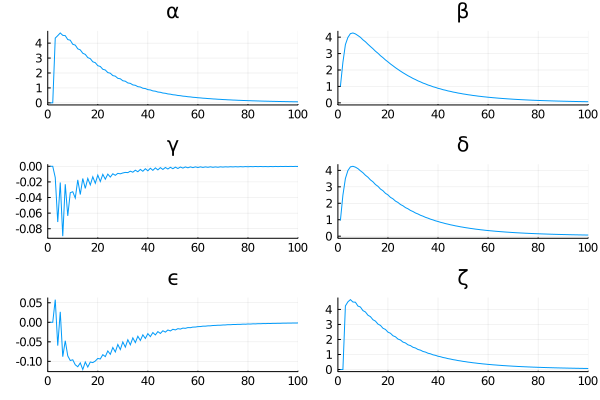

In [7]:
using Parameters
@unpack α,β,γ,δ,ϵ,ζ = aerosol_optics_NAI2.greek_coefs
p1 = plot(α,  title="α")
p2 = plot(β,  title="β")
p3 = plot(γ,  title="γ")
p4 = plot(δ,  title="δ")
p5 = plot(ϵ,  title="ϵ")
p6 = plot(ζ,  title="ζ")
plot(p1, p2, p3, p4, p5, p6, layout=(3, 2), legend=false)
xlims!(0,100)

In [8]:
using FastGaussQuadrature
μ, w_μ = gausslegendre(1000)
# Reconstruct Phase Functions from greek coefficients (overkill for Siewert, mostly for Wigner method)
f₁₁, f₁₂, f₂₂, f₃₃, f₃₄, f₄₄ = PhaseFunction.reconstruct_phase(aerosol_optics_NAI2.greek_coefs, μ);

---
#### Plot only phase function for I (f₁₁) and the I -> Q transition in the phase matrix (f₁₂) for the Stokes Vector [I,Q,U,V]

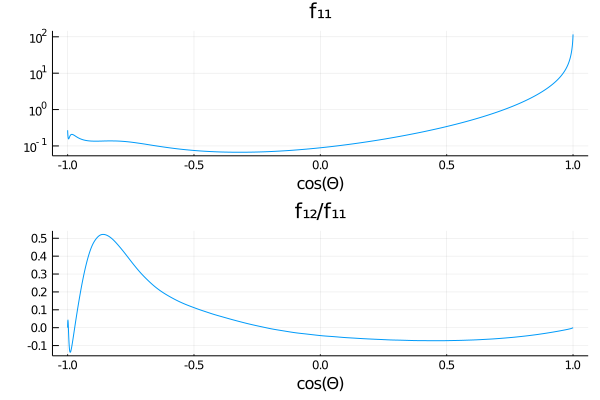

In [9]:

p1 = plot(μ, f₁₁, yscale=:log10, title="f₁₁")
p2 = plot(μ, f₁₂ ./ f₁₁,  title="f₁₂/f₁₁")

plot(p1, p2, layout=(2, 1), legend=false)
xlabel!("cos(Θ)")

In [38]:
anim = @animate for r = 0.1:0.05:2.5
    local size_distribution = LogNormal(log(r), log(1.3))
    # Create the aerosol
    local aero            = make_univariate_aerosol(size_distribution, r_max, n, nᵣ, nᵢ)
    local model_NAI2_760  = make_mie_model(NAI2(), aero, 0.76, polarization_type, truncation_type)
    local model_NAI2_1600 = make_mie_model(NAI2(), aero, 1.6, polarization_type, truncation_type)
    local model_NAI2_2060 = make_mie_model(NAI2(), aero, 2.06, polarization_type, truncation_type)
    local aerosol_optics_NAI2_760  = compute_aerosol_optical_properties(model_NAI2_760);
    local aerosol_optics_NAI2_1600 = compute_aerosol_optical_properties(model_NAI2_1600);
    local aerosol_optics_NAI2_2060 = compute_aerosol_optical_properties(model_NAI2_2060);
    local f₁₁_760, f₁₂_760, f₂₂, f₃₃, f₃₄, f₄₄ = PhaseFunction.reconstruct_phase(aerosol_optics_NAI2_760.greek_coefs, μ);
    local f₁₁_1600, f₁₂_1600, f₂₂, f₃₃, f₃₄, f₄₄ = PhaseFunction.reconstruct_phase(aerosol_optics_NAI2_1600.greek_coefs, μ);
    local f₁₁_2060, f₁₂_2060, f₂₂, f₃₃, f₃₄, f₄₄ = PhaseFunction.reconstruct_phase(aerosol_optics_NAI2_2060.greek_coefs, μ);
    # @show f₁₁[1]
    p1 = plot(acosd.(μ), [f₁₁_760,f₁₁_1600,f₁₁_2060], yscale=:log10, title="f₁₁, r(μm)=$r", label=["760nm" "1600nm" "2060nm"], lw=2, legend=:topleft, size = (600, 400))
    ylims!(5e-2, 2e0)
    xlims!(120,180)
    p2 = plot(acosd.(μ), [f₁₂_760  ./ f₁₁_760,f₁₂_1600 ./ f₁₁_1600,f₁₂_2060 ./ f₁₁_2060] , legend=false, title="f₁₂/f₁₁",lw=2, size = (600, 400))
    ylims!(-1.1, 1.1)
    xlims!(120,180)
    plot(p1, p2, layout=(2, 1))
end

┌ Warning: Assignment to `p1` in soft scope is ambiguous because a global variable by the same name exists: `p1` will be treated as a new local. Disambiguate by using `local p1` to suppress this warning or `global p1` to assign to the existing global variable.
└ @ nothing In[38]:15
┌ Warning: Assignment to `p2` in soft scope is ambiguous because a global variable by the same name exists: `p2` will be treated as a new local. Disambiguate by using `local p2` to suppress this warning or `global p2` to assign to the existing global variable.
└ @ nothing In[38]:18
┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/cfranken/GDrive/work/code/GitHub/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:261
┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/cfranken/GDrive/work/code/GitHub/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:261
┌ Info: Fraction of si

┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/cfranken/GDrive/work/code/GitHub/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:261
┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/cfranken/GDrive/work/code/GitHub/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:261
┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/cfranken/GDrive/work/code/GitHub/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:261
┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/cfranken/GDrive/work/code/GitHub/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:261
┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/cfranken/GDrive/work/code/GitHub/RadiativeTransfer.jl/src/PhaseFunctio

┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/cfranken/GDrive/work/code/GitHub/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:261
┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/cfranken/GDrive/work/code/GitHub/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:261
┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/cfranken/GDrive/work/code/GitHub/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:261
┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/cfranken/GDrive/work/code/GitHub/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:261
┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/cfranken/GDrive/work/code/GitHub/RadiativeTransfer.jl/src/PhaseFunctio

┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/cfranken/GDrive/work/code/GitHub/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:261
┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/cfranken/GDrive/work/code/GitHub/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:261
┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/cfranken/GDrive/work/code/GitHub/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:261
┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/cfranken/GDrive/work/code/GitHub/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:261
┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/cfranken/GDrive/work/code/GitHub/RadiativeTransfer.jl/src/PhaseFunctio

Animation("/var/folders/hs/q1s0d35930l_6ycv7zrhm5rc0000gn/T/jl_Im7WHh", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000040.png", "000041.png", "000042.png", "000043.png", "000044.png", "000045.png", "000046.png", "000047.png", "000048.png", "000049.png"])

┌ Info: Saved animation to 
│   fn = /Users/cfranken/GDrive/work/code/GitHub/RadiativeTransfer.jl/src/Notebooks/tmp.gif
└ @ Plots /Users/cfranken/.julia/packages/Plots/LWw1t/src/animation.jl:104


Plots.AnimatedGif("/Users/cfranken/GDrive/work/code/GitHub/RadiativeTransfer.jl/src/Notebooks/tmp.gif")
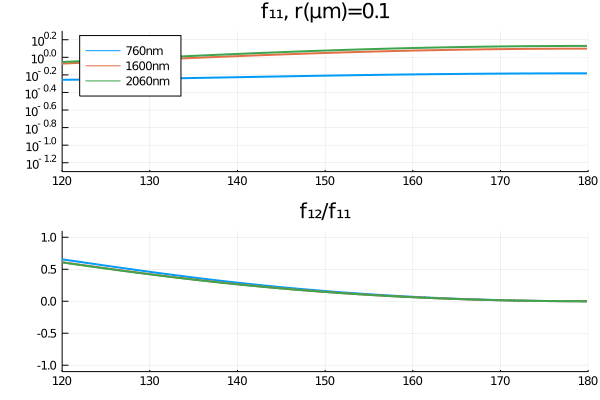

In [39]:
gif(anim, fps = 5)